# Real estate market insights — visual analysis notebook

This notebook loads `../data/listings_data.csv`, runs checks, creates metrics, builds charts, and saves images to `../dashboards/`.

## How to use
1. Put this file in: `real-estate-market-insights/notebooks/cleaning_and_visuals.ipynb`
2. Put your dataset in: `real-estate-market-insights/data/listings_data.csv`
3. Run cells from top to bottom.


In [29]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths (assumes this notebook sits in /notebooks)
ROOT = Path(r"D:\Downloads\data-portfolio\real-estate-market-insights")
DATA_PATH = ROOT / 'data' / 'listings_data.CSV'
DASH_DIR = ROOT / 'dashboards'
REPORTS_DIR = ROOT / 'reports'

DASH_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

DATA_PATH.exists(), DATA_PATH

(True,
 WindowsPath('D:/Downloads/data-portfolio/real-estate-market-insights/data/listings_data.CSV'))

In [30]:
# Load
df = pd.read_csv(DATA_PATH)

# Basic cleanup
df.columns = [c.strip() for c in df.columns]
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Ensure numeric columns are numeric
for col in ['price', 'views', 'leads', 'bedrooms', 'bathrooms']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df.head()

,listing_id,date,location,property_type,bedrooms,bathrooms,price,views,leads,source
0,1,2023-01-10,Kilimani,Apartment,2,2,85000,430,21,organic
1,2,2023-01-14,Ruiru,Apartment,1,1,28000,240,12,organic
2,3,2023-01-22,Westlands,Apartment,3,2,120000,400,18,paid
3,4,2023-02-05,Kileleshwa,Apartment,2,2,95000,310,14,organic
4,5,2023-02-18,Roysambu,Apartment,1,1,25000,300,13,organic


In [31]:
# Data quality checks
print('Rows:', len(df))
print('Date range:', df['date'].min(), '→', df['date'].max())

missing = df.isna().mean().sort_values(ascending=False)
missing[missing > 0]

Rows: 65
Date range: 2023-01-10 00:00:00 → 2024-12-19 00:00:00


Series([], dtype: float64)

In [32]:
# Drop rows with missing core fields
core_cols = ['date', 'location', 'price', 'views', 'leads']
df = df.dropna(subset=core_cols).copy()

# Remove bad values
df = df[(df['views'] >= 0) & (df['leads'] >= 0) & (df['price'] > 0)].copy()

# Feature engineering
df['conversion_rate'] = np.where(df['views'] > 0, (df['leads'] / df['views']) * 100, np.nan)
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()

df[['date','location','price','views','leads','conversion_rate']].head()

,date,location,price,views,leads,conversion_rate
0,2023-01-10,Kilimani,85000,430,21,4.883721
1,2023-01-14,Ruiru,28000,240,12,5.000000
2,2023-01-22,Westlands,120000,400,18,4.500000
3,2023-02-05,Kileleshwa,95000,310,14,4.516129
4,2023-02-18,Roysambu,25000,300,13,4.333333


## 1) Monthly trend: views and leads


In [33]:
monthly = df.groupby('month', as_index=True).agg(
    views=('views','sum'),
    leads=('leads','sum'),
    avg_conversion=('conversion_rate','mean')
).sort_index()

monthly

,views,leads,avg_conversion
month,,,
2023-01-01,1070,51,4.794574
2023-02-01,610,27,4.424731
2023-03-01,950,43,4.586466
2023-04-01,985,48,4.761656
2023-05-01,940,43,4.499663
2023-06-01,840,36,4.328884
2023-07-01,1105,58,5.180923
2023-08-01,1330,62,4.598534
2023-09-01,845,41,4.846939


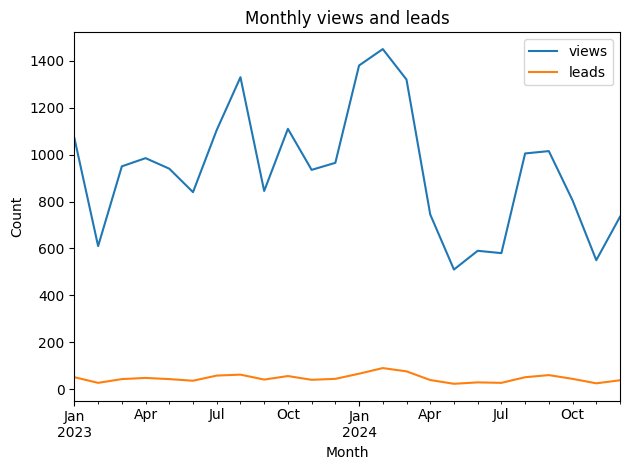

WindowsPath('D:/Downloads/data-portfolio/real-estate-market-insights/dashboards/01_monthly_views_leads.png')

In [34]:
ax = monthly[['views','leads']].plot(kind='line')
ax.set_title('Monthly views and leads')
ax.set_xlabel('Month')
ax.set_ylabel('Count')
plt.tight_layout()

out_path = DASH_DIR / '01_monthly_views_leads.png'
plt.savefig(out_path, dpi=200)
plt.show()
out_path

## 2) Conversion rate by location


In [35]:
loc = df.groupby('location', as_index=True).agg(
    listings=('listing_id','nunique'),
    views=('views','sum'),
    leads=('leads','sum'),
    avg_price=('price','mean'),
)
loc['conversion_rate'] = np.where(loc['views'] > 0, (loc['leads'] / loc['views']) * 100, np.nan)

loc = loc.sort_values('conversion_rate', ascending=False)
loc

,listings,views,leads,avg_price,conversion_rate
location,,,,,
Lavington,3,1430,87,171666.666667,6.083916
Karen,5,2555,151,226000.000000,5.909980
Kilimani,7,3065,167,102000.000000,5.448613
Kileleshwa,5,1720,89,117600.000000,5.174419
Ruaka,5,1505,77,57000.000000,5.116279
Parklands,3,1115,56,126666.666667,5.022422
Nakuru CBD,3,885,43,70666.666667,4.858757
Kitengela,4,965,46,59250.000000,4.766839
Westlands,4,1565,73,106750.000000,4.664537


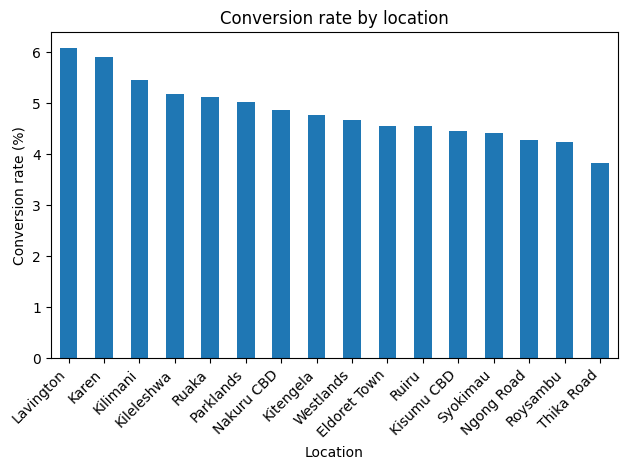

WindowsPath('D:/Downloads/data-portfolio/real-estate-market-insights/dashboards/02_conversion_by_location.png')

In [36]:
ax = loc['conversion_rate'].plot(kind='bar')
ax.set_title('Conversion rate by location')
ax.set_xlabel('Location')
ax.set_ylabel('Conversion rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

out_path = DASH_DIR / '02_conversion_by_location.png'
plt.savefig(out_path, dpi=200)
plt.show()
out_path

## 3) Lead quality by traffic source


In [37]:
src = df.groupby('source', as_index=True).agg(
    views=('views','sum'),
    leads=('leads','sum'),
    avg_price=('price','mean')
)
src['conversion_rate'] = np.where(src['views'] > 0, (src['leads'] / src['views']) * 100, np.nan)
src = src.sort_values('conversion_rate', ascending=False)
src

,views,leads,avg_price,conversion_rate
source,,,,
paid,6135,337,155714.285714,5.493073
organic,13790,671,73380.952381,4.865845
referral,1250,57,57200.000000,4.560000
direct,1195,52,47000.000000,4.351464


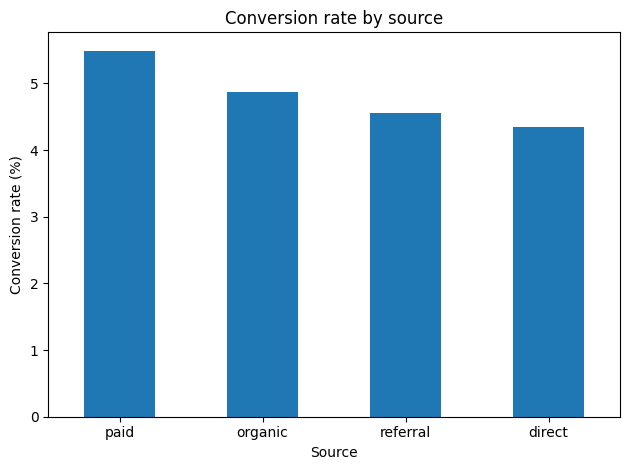

WindowsPath('D:/Downloads/data-portfolio/real-estate-market-insights/dashboards/03_conversion_by_source.png')

In [38]:
ax = src['conversion_rate'].plot(kind='bar')
ax.set_title('Conversion rate by source')
ax.set_xlabel('Source')
ax.set_ylabel('Conversion rate (%)')
plt.xticks(rotation=0)
plt.tight_layout()

out_path = DASH_DIR / '03_conversion_by_source.png'
plt.savefig(out_path, dpi=200)
plt.show()
out_path

## 4) Price vs conversion

This plot helps you explain whether higher price listings convert better or worse.


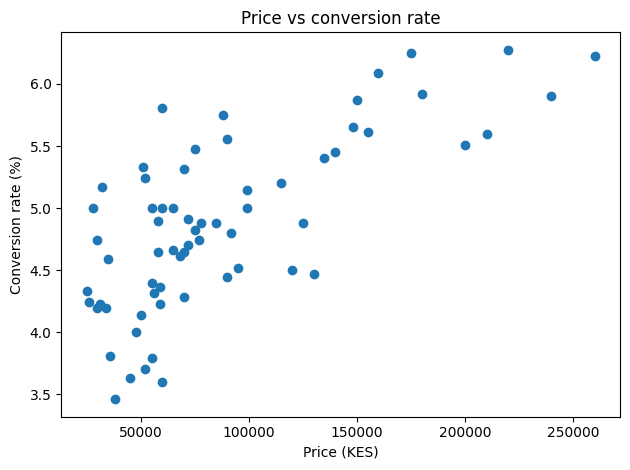

WindowsPath('D:/Downloads/data-portfolio/real-estate-market-insights/dashboards/04_price_vs_conversion.png')

In [39]:
plt.figure()
plt.scatter(df['price'], df['conversion_rate'])
plt.title('Price vs conversion rate')
plt.xlabel('Price (KES)')
plt.ylabel('Conversion rate (%)')
plt.tight_layout()

out_path = DASH_DIR / '04_price_vs_conversion.png'
plt.savefig(out_path, dpi=200)
plt.show()
out_path

## 5) Price bands per location

This creates price bands within each location and shows which band converts best.


In [40]:
df2 = df.copy()

# Create price band per location using quartiles
df2['price_band'] = df2.groupby('location')['price'].transform(
    lambda s: pd.qcut(s, q=min(4, s.nunique()), duplicates='drop')
)

band = df2.groupby(['location','price_band'], as_index=False).agg(
    views=('views','sum'),
    leads=('leads','sum'),
    avg_price=('price','mean'),
)
band['conversion_rate'] = np.where(band['views'] > 0, (band['leads'] / band['views']) * 100, np.nan)

# Show top bands overall
band.sort_values('conversion_rate', ascending=False).head(15)

,location,price_band,views,leads,avg_price,conversion_rate
4,Karen,"(210000.0, 220000.0]",510,32,220000.0,6.274510
22,Lavington,"(170000.0, 176666.667]",480,30,175000.0,6.250000
6,Karen,"(240000.0, 260000.0]",530,33,260000.0,6.226415
21,Lavington,"(159999.999, 170000.0]",460,28,160000.0,6.086957
23,Lavington,"(176666.667, 180000.0]",490,29,180000.0,5.918367
5,Karen,"(220000.0, 240000.0]",525,31,240000.0,5.904762
38,Ruaka,"(52000.0, 60000.0]",310,18,60000.0,5.806452
13,Kilimani,"(119000.0, 150000.0]",920,53,149000.0,5.760870
9,Kileleshwa,"(140000.0, 155000.0]",410,23,155000.0,5.609756
12,Kilimani,"(88000.0, 119000.0]",450,25,90000.0,5.555556


In [41]:
# Pick top 8 locations by total views and plot their best price bands
top_locs = loc.sort_values('views', ascending=False).head(8).index.tolist()
band_top = band[band['location'].isin(top_locs)].copy()

# For each location, keep the best converting band
best_band = (band_top.sort_values(['location','conversion_rate'], ascending=[True, False])
                  .groupby('location', as_index=False)
                  .head(1)
                  .sort_values('conversion_rate', ascending=False))

best_band[['location','price_band','avg_price','conversion_rate','views','leads']]

,location,price_band,avg_price,conversion_rate,views,leads
4,Karen,"(210000.0, 220000.0]",220000.0,6.274510,510,32
22,Lavington,"(170000.0, 176666.667]",175000.0,6.250000,480,30
38,Ruaka,"(52000.0, 60000.0]",60000.0,5.806452,310,18
13,Kilimani,"(119000.0, 150000.0]",149000.0,5.760870,920,53
9,Kileleshwa,"(140000.0, 155000.0]",155000.0,5.609756,410,23
41,Ruiru,"(30500.0, 33000.0]",32000.0,5.172414,290,15
54,Westlands,"(121250.0, 125000.0]",125000.0,4.883721,430,21
33,Roysambu,"(24999.999, 25750.0]",25000.0,4.333333,300,13


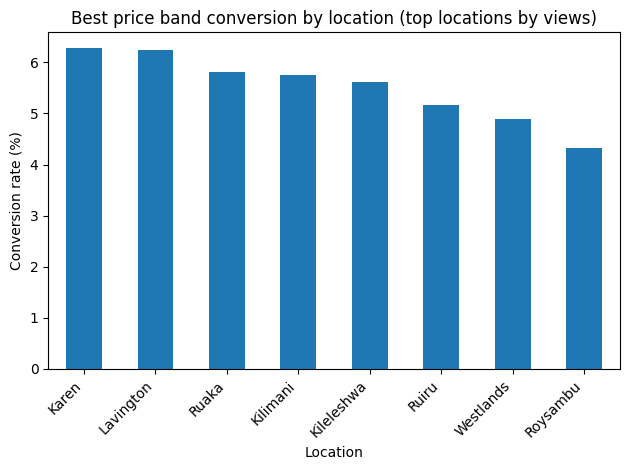

WindowsPath('D:/Downloads/data-portfolio/real-estate-market-insights/dashboards/05_best_price_band_by_location.png')

In [42]:
ax = best_band.set_index('location')['conversion_rate'].plot(kind='bar')
ax.set_title('Best price band conversion by location (top locations by views)')
ax.set_xlabel('Location')
ax.set_ylabel('Conversion rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

out_path = DASH_DIR / '05_best_price_band_by_location.png'
plt.savefig(out_path, dpi=200)
plt.show()
out_path

## 6) Property type performance


In [43]:
ptype = df.groupby('property_type', as_index=True).agg(
    views=('views','sum'),
    leads=('leads','sum'),
    avg_price=('price','mean')
)
ptype['conversion_rate'] = np.where(ptype['views'] > 0, (ptype['leads'] / ptype['views']) * 100, np.nan)
ptype = ptype.sort_values('conversion_rate', ascending=False)
ptype

,views,leads,avg_price,conversion_rate
property_type,,,,
Bungalow,4625,247,126461.538462,5.340541
Apartment,17745,870,78692.307692,4.902790


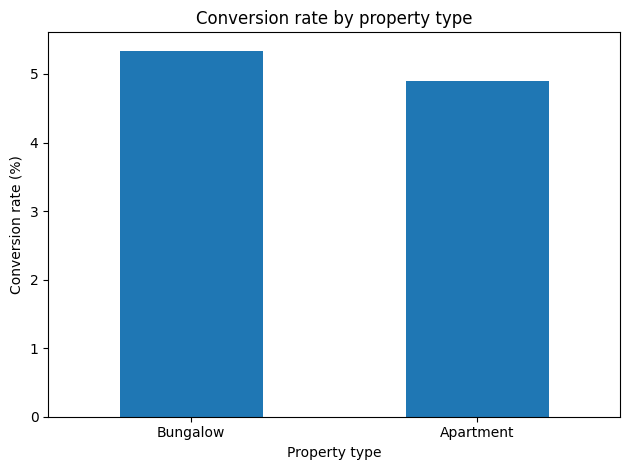

WindowsPath('D:/Downloads/data-portfolio/real-estate-market-insights/dashboards/06_conversion_by_property_type.png')

In [44]:
ax = ptype['conversion_rate'].plot(kind='bar')
ax.set_title('Conversion rate by property type')
ax.set_xlabel('Property type')
ax.set_ylabel('Conversion rate (%)')
plt.xticks(rotation=0)
plt.tight_layout()

out_path = DASH_DIR / '06_conversion_by_property_type.png'
plt.savefig(out_path, dpi=200)
plt.show()
out_path

## 7) Simple interview-ready summary

This cell writes a short summary file to `../reports/insights_summary.md`.
You can edit it after you run the notebook.


In [45]:
top_conv_locations = loc.head(5).reset_index()[['location','conversion_rate','views','leads','avg_price']]
top_sources = src.head(4).reset_index()[['source','conversion_rate','views','leads','avg_price']]

peak_month = monthly['views'].idxmax()
low_month = monthly['views'].idxmin()

lines = []
lines.append('# insights summary')
lines.append('')
lines.append(f'- rows analyzed: **{len(df):,}**')
lines.append(f"- date range: **{df['date'].min().date()}** to **{df['date'].max().date()}**")
lines.append(f'- peak month by views: **{peak_month.date()}**')
lines.append(f'- lowest month by views: **{low_month.date()}**')
lines.append('')
lines.append('## top locations by conversion rate')
lines.append('')
lines.append(top_conv_locations.to_markdown(index=False))
lines.append('')
lines.append('## top sources by conversion rate')
lines.append('')
lines.append(top_sources.to_markdown(index=False))
lines.append('')
lines.append('## notes for interviews')
lines.append('')
lines.append('- I compared conversion rates across locations, sources, and price levels.')
lines.append('- I used monthly trends to explain seasonality and demand shifts.')
lines.append('- I used price bands per location to show that the best converting range can differ by area.')
lines.append('- I exported charts as PNG files so the dashboard folder stays visible in GitHub.')

report_path = REPORTS_DIR / 'insights_summary.md'
report_path.write_text('\n'.join(lines), encoding='utf-8')

report_path

WindowsPath('D:/Downloads/data-portfolio/real-estate-market-insights/reports/insights_summary.md')

## 8) What to upload to GitHub

After you run this notebook, upload these files:

- `data/listings_data.csv`
- `notebooks/cleaning_and_visuals.ipynb`
- All PNG files created in `dashboards/`
- `reports/insights_summary.md`
